```{note}
This notebook is a duplicate of the one found in the [JaxKern documentation](https://jaxkern.readthedocs.io/en/latest/nbs/kernels.html). It is included here for completeness.
```
# Kernel Guide

In this guide, we introduce the kernels available in GPJax and demonstrate how to create custom ones.

In [1]:
import distrax as dx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import jit
from jax.config import config
from jaxtyping import Array, Float
from optax import adam
from typing import Dict
from jaxutils import Dataset
import jaxkern as jk

import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)

## Supported Kernels

The following kernels are natively supported in GPJax.

* Matérn 1/2, 3/2 and 5/2.
* RBF (or squared exponential).
* Polynomial.
* [Graph kernels](https://gpjax.readthedocs.io/en/latest/nbs/graph_kernels.html).

While the syntax is consistent, each kernel’s type influences the
characteristics of the sample paths drawn. We visualise this below with 10
function draws per kernel.

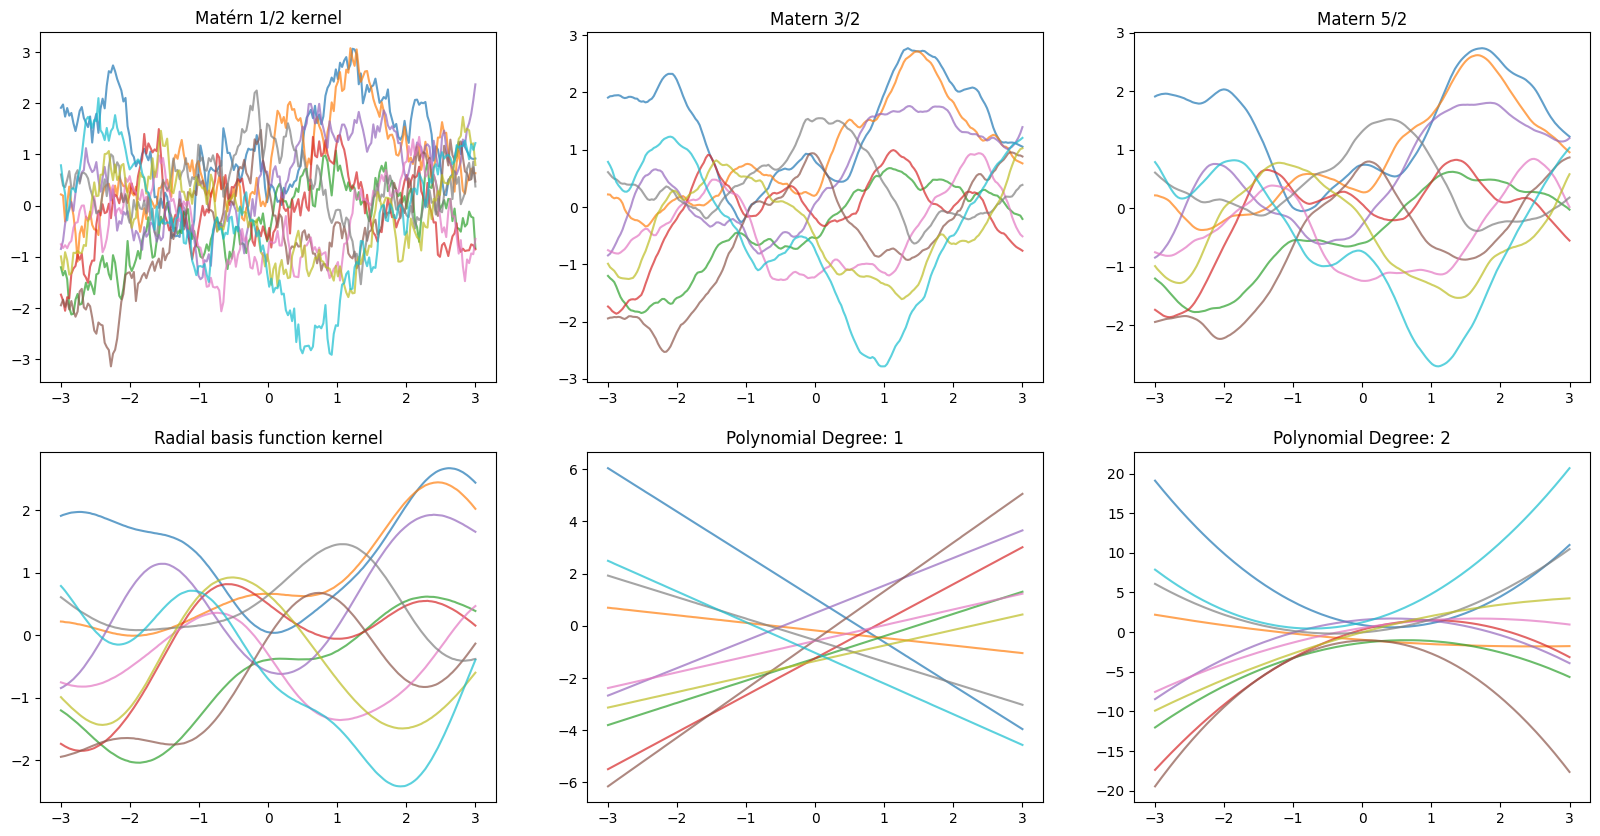

In [2]:
kernels = [
    jk.Matern12(),
    jk.Matern32(),
    jk.Matern52(),
    jk.RBF(),
    jk.Polynomial(),
    jk.Polynomial(degree=2),
]
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))

x = jnp.linspace(-3.0, 3.0, num=200).reshape(-1, 1)

for k, ax in zip(kernels, axes.ravel()):
    prior = gpx.Prior(kernel=k)
    params, *_ = gpx.initialise(prior, key).unpack()
    rv = prior(params)(x)
    y = rv.sample(seed=key, sample_shape=(10,))
    ax.plot(x, y.T, alpha=0.7)
    ax.set_title(k.name)

### Active dimensions

By default, kernels operate over every dimension of the supplied inputs. In
some use cases, it is desirable to restrict kernels to specific dimensions of
the input data. We can achieve this by the `active dims` argument, which
determines which input index values the kernel evaluates.

To see this, consider the following 5-dimensional dataset for which we would
like our RBF kernel to act on the first, second and fourth dimensions.

In [3]:
slice_kernel = jk.RBF(active_dims=[0, 1, 3])


The resulting kernel has one length-scale parameter per input dimension --- an ARD kernel.

In [4]:
print(f"ARD: {slice_kernel.ard}")
print(f"Lengthscales: {slice_kernel.init_params(key)['lengthscale']}")

ARD: True
Lengthscales: [1. 1. 1.]


We'll now simulate some data and evaluate the kernel on the previously selected input dimensions.

In [5]:
# Inputs
x_matrix = jr.normal(key, shape=(50, 5))

# Default parameter dictionary
params = slice_kernel.init_params(key)

# Compute the Gram matrix
K = slice_kernel.gram(params, x_matrix)
print(K.shape)

(50, 50)


## Kernel combinations

The product or sum of two positive definite matrices yields a positive
definite matrix. Consequently, summing or multiplying sets of kernels is a
valid operation that can give rich kernel functions. In GPJax, sums of kernels
can be created by applying the `+` operator as follows.

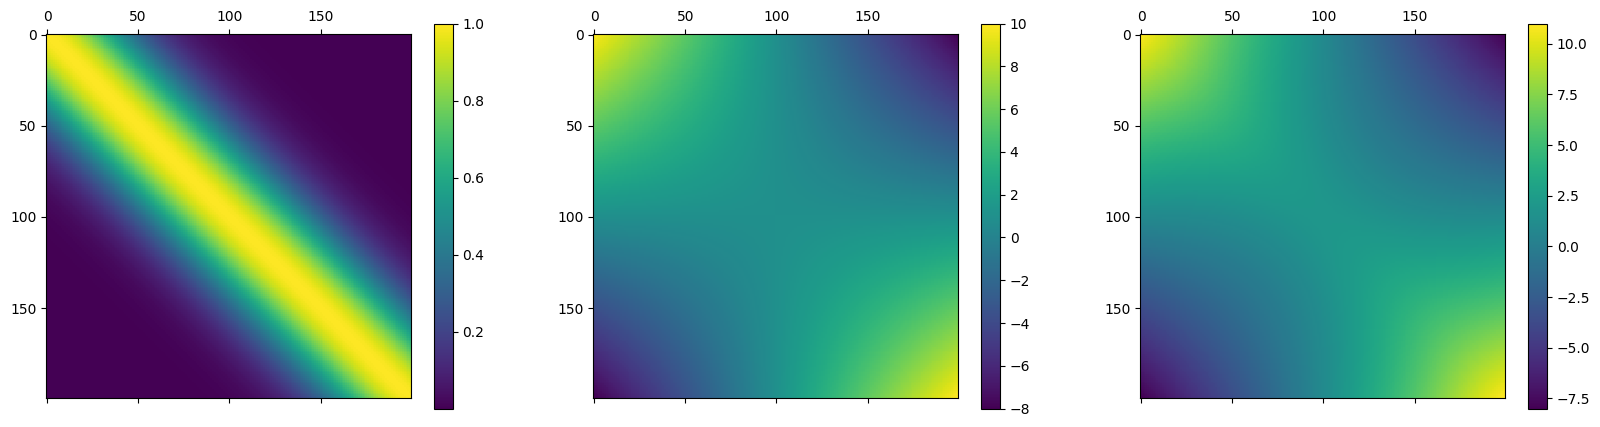

In [6]:
k1 = jk.RBF()
k2 = jk.Polynomial()
sum_k = k1 + k2

fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
im0 = ax[0].matshow(k1.gram(k1.init_params(key), x).to_dense())
im1 = ax[1].matshow(k2.gram(k2.init_params(key), x).to_dense())
im2 = ax[2].matshow(sum_k.gram(sum_k.init_params(key), x).to_dense())

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])

Similarily, products of kernels can be created through the `*` operator.

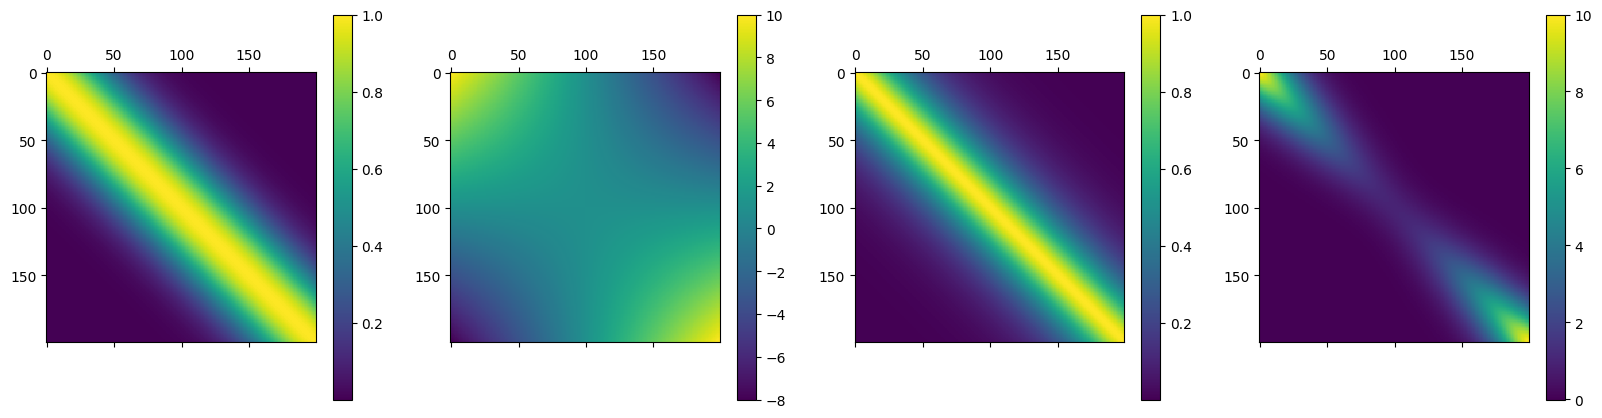

In [7]:
k3 = jk.Matern32()

prod_k = k1 * k2 * k3

fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
im0 = ax[0].matshow(k1.gram(k1.init_params(key), x).to_dense())
im1 = ax[1].matshow(k2.gram(k2.init_params(key), x).to_dense())
im2 = ax[2].matshow(k3.gram(k3.init_params(key), x).to_dense())
im3 = ax[3].matshow(prod_k.gram(prod_k.init_params(key), x).to_dense())

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])
fig.colorbar(im3, ax=ax[3])

Alternatively kernel sums and multiplications can be created by passing a list of kernels into the `SumKernel` `ProductKernel` objects respectively.

In [8]:
sum_k = jk.SumKernel(kernel_set=[k1, k2])
prod_k = jk.ProductKernel(kernel_set=[k1, k2, k3])

## Custom kernel

GPJax makes the process of implementing kernels of your choice straightforward
with two key steps:

1. Listing the kernel's parameters.
2. Defining the kernel's pairwise operation.

We'll demonstrate this process now for a circular kernel --- an adaption of
the excellent guide given in the PYMC3 documentation. We encourage curious
readers to visit their notebook
[here](https://docs.pymc.io/pymc-examples/examples/gaussian_processes/GP-Circular.html).

### Circular kernel

When the underlying space is polar, typical Euclidean kernels such as Matérn
kernels are insufficient at the boundary as discontinuities will be present.
This is due to the fact that for a polar space $\lvert 0, 2\pi\rvert=0$ i.e.,
the space wraps. Euclidean kernels have no mechanism in them to represent this
logic and will instead treat $0$ and $2\pi$ and elements far apart. Circular
kernels do not exhibit this behaviour and instead _wrap_ around the boundary
points to create a smooth function. Such a kernel was given in [Padonou &
Roustant (2015)](https://hal.inria.fr/hal-01119942v1) where any two angles
$\theta$ and $\theta'$ are written as $$W_c(\theta, \theta') = \left\lvert
\left(1 + \tau \frac{d(\theta, \theta')}{c} \right) \left(1 - \frac{d(\theta,
\theta')}{c} \right)^{\tau} \right\rvert \quad \tau \geq 4 \tag{1}.$$

Here the hyperparameter $\tau$ is analogous to a lengthscale for Euclidean
stationary kernels, controlling the correlation between pairs of observations.
While $d$ is an angular distance metric

$$d(\theta, \theta') = \lvert (\theta-\theta'+c) \operatorname{mod} 2c - c
\rvert.$$

To implement this, one must write the following class.

In [9]:
def angular_distance(x, y, c):
    return jnp.abs((x - y + c) % (c * 2) - c)


class Polar(jk.kernels.AbstractKernel):
    def __init__(self) -> None:
        super().__init__()
        self.period: float = 2 * jnp.pi
        self.c = self.period / 2.0  # in [0, \pi]

    def __call__(
        self, params: Dict, x: Float[Array, "1 D"], y: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:
        tau = params["tau"]
        t = angular_distance(x, y, self.c)
        K = (1 + tau * t / self.c) * jnp.clip(1 - t / self.c, 0, jnp.inf) ** tau
        return K.squeeze()

    def init_params(self, key: jr.KeyArray) -> dict:
        return {"tau": jnp.array([4.0])}

    # This is depreciated. Can be removed once JaxKern is updated.
    def _initialise_params(self, key: jr.KeyArray) -> Dict:
        return self.init_params(key)

We unpack this now to make better sense of it. In the kernel's `__init__`
function we simply specify the length of a single period. As the underlying
domain is a circle, this is $2\pi$. Next we define the kernel's `__call__`
function which is a direct implementation of Equation (1). Finally, we define
the Kernel's parameter property which contains just one value $\tau$ that we
initialise to 4 in the kernel's `__init__`.


### Custom Parameter Bijection

The constraint on $\tau$ makes optimisation challenging with gradient descent.
It would be much easier if we could instead parameterise $\tau$ to be on the
real line. Fortunately, this can be taken care of with GPJax's `add parameter`
function, only requiring us to define the parameter's name and matching
bijection (either a Distrax of TensorFlow probability bijector). Under the
hood, calling this function updates a configuration object to register this
parameter and its corresponding transform.

To define a bijector here we'll make use of the `Lambda` operator given in
Distrax. This lets us convert any regular Jax function into a bijection. Given
that we require $\tau$ to be strictly greater than $4.$, we'll apply a
[softplus
transformation](https://jax.readthedocs.io/en/latest/_autosummary/jax.nn.softplus.html)
where the lower bound is shifted by $4$.

In [10]:
from jax.nn import softplus
from gpjax.config import add_parameter

bij_fn = lambda x: softplus(x + jnp.array(4.0))
bij = dx.Lambda(
    forward=bij_fn, inverse=lambda y: -jnp.log(-jnp.expm1(-y - 4.0)) + y - 4.0
)

add_parameter("tau", bij)

/var/folders/qb/c3b8rx055411rkfvdyzty9_80000gn/T/ipykernel_99210/1443129282.py:9: DeprecatedWarning: add_parameter is deprecated as of 0.5.6 and will be removed in 0.6.0. Use method from jaxutils.config instead.
  add_parameter("tau", bij)


### Using our polar kernel

We proceed to fit a GP with our custom circular kernel to a random sequence of points on a circle (see the [Regression notebook](https://gpjax.readthedocs.io/en/latest/nbs/regression.html) for further details on this process).

In [11]:
# Simulate data
angles = jnp.linspace(0, 2 * jnp.pi, num=200).reshape(-1, 1)
n = 20
noise = 0.2

X = jnp.sort(jr.uniform(key, minval=0.0, maxval=jnp.pi * 2, shape=(n, 1)), axis=0)
y = 4 + jnp.cos(2 * X) + jr.normal(key, shape=X.shape) * noise

D = Dataset(X=X, y=y)

# Define polar Gaussian process
PKern = Polar()
likelihood = gpx.Gaussian(num_datapoints=n)
circlular_posterior = gpx.Prior(kernel=PKern) * likelihood

# Initialise parameter state:
parameter_state = gpx.initialise(circlular_posterior, key)

# Optimise GP's marginal log-likelihood using Adam
negative_mll = jit(circlular_posterior.marginal_log_likelihood(D, negative=True))
optimiser = adam(learning_rate=0.05)

inference_state = gpx.fit(
    objective=negative_mll,
    parameter_state=parameter_state,
    optax_optim=optimiser,
    num_iters=1000,
)

learned_params, training_history = inference_state.unpack()

  0%|          | 0/1000 [00:00<?, ?it/s]

### Prediction

We'll now query the GP's predictive posterior at linearly spaced novel inputs
and illustrate the results.

In [12]:
posterior_rv = likelihood(
    learned_params, circlular_posterior(learned_params, D)(angles)
)
mu = posterior_rv.mean()
one_sigma = posterior_rv.stddev()

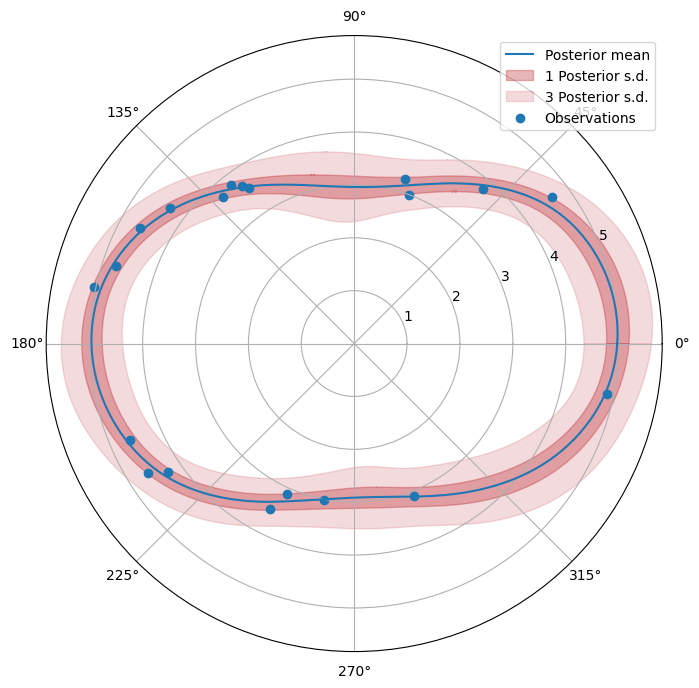

In [13]:
fig = plt.figure(figsize=(10, 8))
gridspec = fig.add_gridspec(1, 1)
ax = plt.subplot(gridspec[0], polar=True)

ax.fill_between(
    angles.squeeze(),
    mu - one_sigma,
    mu + one_sigma,
    alpha=0.3,
    label=r"1 Posterior s.d.",
    color="#B5121B",
)
ax.fill_between(
    angles.squeeze(),
    mu - 3 * one_sigma,
    mu + 3 * one_sigma,
    alpha=0.15,
    label=r"3 Posterior s.d.",
    color="#B5121B",
)
ax.plot(angles, mu, label="Posterior mean")
ax.scatter(D.X, D.y, alpha=1, label="Observations")
ax.legend()

## System configuration

In [14]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Thomas Pinder (edited by Daniel Dodd)'

Author: Thomas Pinder (edited by Daniel Dodd)

Last updated: Sat Jan 14 2023

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.8.0

jaxkern   : 0.0.4
gpjax     : 0.5.8
matplotlib: 3.3.3
distrax   : 0.1.2
jax       : 0.4.1

Watermark: 2.3.1

